In [49]:
import pandas as pd
import numpy as np

train1 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train.csv')
# test1 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test.csv")

train2 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train_extends.csv')

target='target'
IDcol = 'id'
tag='tag'


In [50]:
print train2.columns

Index([u'id', u'target', u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin',
       u'ps_ind_07_bin', u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin',
       u'ps_ind_11_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=175)


In [51]:
#拆分数据集
from sklearn.cross_validation import train_test_split  

#标注正样本和负样本
train1_pos=train1[train1['target']==1]
print (train1_pos['target'].value_counts())
train1_neg=train1[train1['target']==0]
print (train1_neg['target'].value_counts())

dtypes = train1.dtypes
cols = train1.columns
ty = dict(zip(cols,dtypes))

#df转narray
train1_pos=np.array(train1_pos)
train1_neg=np.array(train1_neg)
#数据集拆分
train1_pos_new,validation1_pos_new = train_test_split(train1_pos,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
train1_neg_new,validation1_neg_new = train_test_split(train1_neg,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
#数据集拼接
train1_new=np.concatenate([train1_pos_new,train1_neg_new],axis=0) #在纵轴上合并

validation1_new=np.concatenate([validation1_pos_new,validation1_neg_new],axis=0) #在纵轴上合并


#修改train、validation、test
train_temp=pd.DataFrame(train1_new)
train_temp.columns=train1.columns
train=train_temp
train_old = train.astype(ty)

validation_temp=pd.DataFrame(validation1_new)
validation_temp.columns=train1.columns
validation=validation_temp
validation_old = validation.astype(ty)


1    21694
Name: target, dtype: int64
0    573518
Name: target, dtype: int64


In [52]:
#拆分数据集
from sklearn.cross_validation import train_test_split  

#标注正样本和负样本
train2_pos=train2[train2['target']==1]
print (train2_pos['target'].value_counts())
train2_neg=train2[train2['target']==0]
print (train2_neg['target'].value_counts())

dtypes = train2.dtypes
cols = train2.columns
ty = dict(zip(cols,dtypes))

#df转narray
train2_pos=np.array(train2_pos)
train2_neg=np.array(train2_neg)
#数据集拆分
train2_pos_new,validation2_pos_new = train_test_split(train2_pos,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
train2_neg_new,validation2_neg_new = train_test_split(train2_neg,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
#数据集拼接
train2_new=np.concatenate([train2_pos_new,train2_neg_new],axis=0) #在纵轴上合并

validation2_new=np.concatenate([validation2_pos_new,validation2_neg_new],axis=0) #在纵轴上合并


#修改train、validation、test
train_temp=pd.DataFrame(train2_new)
train_temp.columns=train2.columns
train=train_temp
train_extends = train.astype(ty)

validation_temp=pd.DataFrame(validation2_new)
validation_temp.columns=train2.columns
validation=validation_temp
validation_extends = validation.astype(ty)

1    21694
Name: target, dtype: int64
0    573518
Name: target, dtype: int64


In [53]:
print train_old.shape
print train_old.dtypes

(476169, 59)
id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64

In [54]:
print train_extends.shape
print train_extends.dtypes


(476169, 175)
id                         int64
target                     int64
ps_ind_01                  int64
ps_ind_03                  int64
ps_ind_06_bin              int64
ps_ind_07_bin              int64
ps_ind_08_bin              int64
ps_ind_09_bin              int64
ps_ind_10_bin              int64
ps_ind_11_bin              int64
ps_ind_12_bin              int64
ps_ind_13_bin              int64
ps_ind_14                  int64
ps_ind_15                  int64
ps_ind_16_bin              int64
ps_ind_17_bin              int64
ps_ind_18_bin              int64
ps_reg_01                float64
ps_reg_02                float64
ps_reg_03                float64
ps_car_11                float64
ps_car_12                float64
ps_car_13                float64
ps_car_14                float64
ps_car_15                float64
ps_calc_01               float64
ps_calc_02               float64
ps_calc_03               float64
ps_calc_04                 int64
ps_calc_05                 in

In [55]:
#模型
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


In [56]:
#评估方法
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / len(actual)

def gini_normalized(a, p):
        return gini(a, p) / gini(a, a)
    


#模型训练
def xgboostModelFit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #模型训练
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #模型预测-训练集
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #输出模型效果-训练集:
    print "\nModel Report- train data"
    print "Accuracy（Train） : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
    print "GINI Score (Train): %f" % gini_normalized(dtrain['target'], dtrain_predprob)
    
    #模型预测-测试集
    dtest['prediction'] = alg.predict(dtest[predictors])
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    #输出模型效果-测试集
    print "\nModel Report- test data"
    print "Accuracy（Test） : %.4g" % metrics.accuracy_score(dtest['target'].values,dtest['prediction'])
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest['target'], dtest['predprob'])
    print "GINI Score (Test): %f" % gini_normalized(dtest['target'], dtest['predprob'])
    
    return alg

In [57]:
predictors1 = [x for x in train_old.columns if x not in [target, IDcol,tag]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

alg_before=xgboostModelFit(xgb1, train1, validation_old, predictors1)


Model Report- train data
Accuracy（Train） : 0.6274
AUC Score (Train): 0.644518
GINI Score (Train): 0.289036

Model Report- test data
Accuracy（Test） : 0.6281
AUC Score (Test): 0.644204
GINI Score (Test): 0.288419


In [58]:
predictors2 = [x for x in train_extends.columns if x not in [target, IDcol,tag]]

xgb2 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

alg_after=xgboostModelFit(xgb2, train_extends, validation_extends, predictors2)


Model Report- train data
Accuracy（Train） : 0.6251
AUC Score (Train): 0.648900
GINI Score (Train): 0.297813

Model Report- test data
Accuracy（Test） : 0.6234
AUC Score (Test): 0.630744
GINI Score (Test): 0.261501


In [59]:
print 	len(predictors1)

57


In [60]:
print len(predictors2)
print train.columns

172
Index([u'id', u'target', u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin',
       u'ps_ind_07_bin', u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin',
       u'ps_ind_11_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=175)


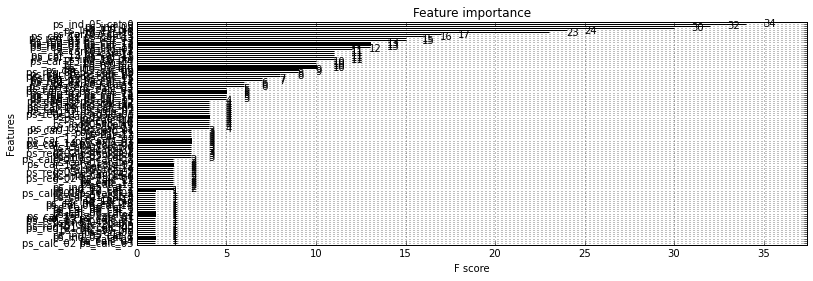

In [61]:
xgb.plot_importance(alg_after,height=0.1)

# 结论

模型及参数相同的情况下，增加特征工程后，对最终结果有正向效果。

特征工程之前： GINI Score (Train)为 0.289036

特征工程之后： GINI Score (Train)为 0.297813

不过，新训练集的训练效果和测试效果差别略大，需要调参数。

# 以下是最终测试数据效果

## 特征工程之前

In [62]:
test1 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test.csv")


In [63]:
#最终测试集
test_raw= test1
X_test_raw= test1[predictors1]
y_raw_test_pred = alg_before.predict(X_test_raw)
y_raw_test_predprob=alg_before.predict_proba(X_test_raw)[:,1]

In [64]:
X_ID = test_raw['id']
X_ID=pd.DataFrame(X_ID)
df_y_test_predprob=pd.DataFrame(y_raw_test_predprob)
print df_y_test_predprob.shape,X_ID.shape

(892816, 1) (892816, 1)


In [65]:
result=pd.concat([X_ID,df_y_test_predprob],axis=1)
result.columns = ['id', 'target']
result.shape

(892816, 2)

In [66]:
result.to_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test_result_old.csv",index=False)

## 特征工程之后

In [67]:
test2 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test_extends.csv")

In [68]:
#最终测试集
test_raw= test2
X_test_raw= test2[predictors2]
y_raw_test_pred = alg_after.predict(X_test_raw)
y_raw_test_predprob=alg_after.predict_proba(X_test_raw)[:,1]

In [69]:
X_ID = test_raw['id']
X_ID=pd.DataFrame(X_ID)
df_y_test_predprob=pd.DataFrame(y_raw_test_predprob)
print df_y_test_predprob.shape,X_ID.shape


(892816, 1) (892816, 1)


In [70]:
result=pd.concat([X_ID,df_y_test_predprob],axis=1)
result.columns = ['id', 'target']
result.shape

(892816, 2)

In [71]:
result.to_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test_result.csv",index=False)

# LB

在leaderboard上，特征工程之前0.260，特征工程之后0.250。